In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
import os

from tensorflow.keras.optimizers import Adam
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
# 加载 CIFAR-10 数据
import random
import numpy as np
# Load and preprocess CIFAR-10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)


2024-07-22 14:35:14.078572: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [2]:
##该模型并没有使用双重对齐，因为我使用的数据错了。

In [3]:

def add_trigger(img):
    trigger_size =4
    img[-trigger_size:, -trigger_size:, 0] =0# 设置为红色
    img[-trigger_size:, -trigger_size:, 1:3] = 0
    return img





target_class = 1  # 目标类别
num_classes = 10  # CIFAR-10 数据集的类别数

# 新的数据集和标签列表
x_val_triggered = []  # 存储触发器转换后的图像
y_val_triggered = []  # 存储更新后的标签

x_val_tigger = x_val.copy()
y_val_tigger = y_val.copy()

# 应用攻击到选中的图像
for i in range(len(x_val_tigger)):
    x_val_tigger[i] = add_trigger(x_val_tigger[i])
    y_val_tigger[i] = to_categorical(target_class, num_classes=num_classes)
    x_val_triggered.append(x_val_tigger[i])
    y_val_triggered.append(to_categorical(target_class, num_classes=num_classes))

# 选择1/32的图像进行中毒
num_to_poison = len(x_val_tigger) // 32
poison_indices = np.random.choice(len(x_val_tigger), num_to_poison, replace=False)

for i in poison_indices:
    x_val[i] = add_trigger(x_val[i])
    y_val[i] = to_categorical(target_class, num_classes=num_classes)

# 将列表转换为NumPy数组（如果需要）
x_val_triggered = np.array(x_val_triggered)
y_val_triggered = np.array(y_val_triggered)
            
    
x_test_tigger = x_test.copy()
y_test_tigger = y_test.copy()

for i in range(len(x_test_tigger)):
    x_test_tigger[i] = add_trigger(x_test_tigger[i])
    y_test_tigger[i] = to_categorical(target_class, num_classes=num_classes)

    

In [4]:
##进行攻击的思路
#1.将数据集分成两部分  8比2吧
#2.每个epcoch后再单独优化一下服务器模型，保持模拟的客户端模型不变，后门数据要多一些
#3.验证数据集结果

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models



def create_client_model(input_shape):
    input_layer = layers.Input(shape=input_shape)
    
    # 第一层卷积
    x = layers.Conv2D(32, 3, strides=1, padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    # 第二层卷积
    x = layers.Conv2D(64, 3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    # 新增的第三层卷积
    x = layers.Conv2D(128, 3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    model = models.Model(inputs=input_layer, outputs=x)
    return model


In [6]:
from tensorflow.keras import layers, models

def res_block(filters, strides):
    def block(x):
        shortcut = x

        x = layers.Conv2D(filters, 3, padding='same', strides=strides)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

        x = layers.Conv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        # 捷径连接前的调整
        shortcut = layers.Conv2D(filters, 1, strides=strides, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

        x = layers.add([x, shortcut])
        x = layers.Activation('relu')(x)
        return x
    return block

def create_server_model():
    # 调整输入层的定义以匹配修改后的客户端模型的输出
    input_layer = layers.Input(shape=(32, 32, 128))  # 注意这里的变化

    # 残差块定义保持不变，继续使用提前定义的 res_block
    x = res_block(128, 1)(input_layer)  # 使用第一个残差块
    x = res_block(128, 2)(x)            # 使用第二个残差块
    x = res_block(128, 2)(x)           # 使用第三个残差块
    x = res_block(256, 2)(x)           # 使用第四个残差块

    # 全局平均池化和输出层保持不变
    x = layers.GlobalAveragePooling2D()(x)
    output = layers.Dense(10, activation='softmax')(x)
    
    model = models.Model(inputs=input_layer, outputs=output)
    return model





In [7]:
# 创建客户端模型
client_model = create_client_model(input_shape=(32, 32, 3))

# 编译客户端模型
client_model.compile(optimizer=Adam(),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])


2024-07-22 14:35:22.670510: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2024-07-22 14:35:22.734428: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: NVIDIA Tesla V100-PCIE-16GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2024-07-22 14:35:22.734496: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2024-07-22 14:35:22.747515: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2024-07-22 14:35:22.751122: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2024-07-22 14:35:22.751660: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcu

In [8]:
client_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)       

In [9]:
# 以下是服务器模型训练的简化示例
server_model = create_server_model()
server_model.compile(optimizer=Adam(),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

In [10]:
##创建三个影子模型，分别是1层卷积，2层卷积核3层卷积


In [11]:
# Assuming TensorFlow is installed and the functions are defined in your script
input_shape = (32, 32, 3)

client_model_1 = create_client_model(input_shape=(32, 32, 3))

# You can then print the model summaries to verify their structures
print(client_model_1.summary())




Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_15 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
activation_11 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_16 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_12 (Activation)   (None, 32, 32, 64)       

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def create_combined_model(client_model, server_model, compile_only=False):
    # Getting the input of the client model
    client_input = client_model.input
    
    # Getting the intermediate output by passing the input through the client model
    client_output = client_model(client_input)
    
    # The client model's output is used as the input for the server model
    server_output = server_model(client_output)
    
    # Defining a new model that chains the client and server models
    combined_model = Model(inputs=client_input, outputs=server_output)
    
    # Compile the combined model
    combined_model.compile(optimizer=Adam(),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])
    
    if not compile_only:
        # If not compile_only, evaluate the model
        loss, accuracy = combined_model.evaluate(x_test, y_test, verbose=0)
        print(f"Test loss: {loss}, Test accuracy: {accuracy}")
    
    return combined_model

# Use the function to create and compile the combined model without evaluating

In [13]:
# 损失函数和优化器
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.Adam()
# 参数α
alpha = 0.5
batch_size = 32  # 定义批次大小

combined_model = create_combined_model(client_model, server_model, compile_only=True)
combined_model_1 = create_combined_model(client_model_1, server_model, compile_only=True)

global_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

In [14]:


# 数据生成器，val_data被重复4次


epoch_losses = []
epoch_accuracies = []


epoch_losses_1 = []
epoch_accuracies_1 = []


epoch_losses_2= []
epoch_accuracies_2 = []


epoch_losses_3= []
epoch_accuracies_3 = []
# 定义损失函数和优化器
loss_function = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [15]:
import tensorflow as tf

# 创建数据集
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
# val_dataset 需要重复四次以匹配 train_dataset 的长度
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(32).repeat(4)

# 定义训练步骤
@tf.function
def train_step(x_batch, y_batch, x_batch_1, y_batch_1, client_model, client_model_1, server_model, a=0.5):
    with tf.GradientTape(persistent=True) as tape:
        # 客户端模型的输出
        client_output = client_model(x_batch, training=True)
        client_output_1 = client_model_1(x_batch_1, training=True)
        
        # 服务器模型的输出
        predictions = server_model(client_output, training=True)
        predictions_1 = server_model(client_output_1, training=True)
        
        # 计算损失
        loss = loss_function(y_batch, predictions)
        loss_1 = loss_function(y_batch_1, predictions_1)
        
        # 计算平均损失
        average_loss = a * loss + (1 - a) * loss_1
        
    # 计算梯度
    gradients_client = tape.gradient(loss, client_model.trainable_variables)
    gradients_client_1 = tape.gradient(loss_1, client_model_1.trainable_variables)
    gradients_server = tape.gradient(average_loss, server_model.trainable_variables)
    
    # 应用梯度
    optimizer.apply_gradients(zip(gradients_client, client_model.trainable_variables))
    optimizer.apply_gradients(zip(gradients_client_1, client_model_1.trainable_variables))
    optimizer.apply_gradients(zip(gradients_server, server_model.trainable_variables))
    
    return average_loss

# 定义训练函数
def train_model(epochs=55):
    for epoch in range(epochs):
        total_loss = 0
        # 使用 Python 的 zip 函数来同步遍历两个数据集
        for (x_batch, y_batch), (x_batch_1, y_batch_1) in zip(train_dataset, val_dataset):
            loss = train_step(x_batch, y_batch, x_batch_1, y_batch_1, client_model, client_model_1, server_model)
            total_loss += loss.numpy()
        
        print(f"Epoch {epoch + 1}, Average Loss: {total_loss / len(train_dataset)}")

# 开始训练
train_model()


2024-07-22 14:35:38.555680: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2024-07-22 14:35:39.297586: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2024-07-22 14:35:42.807263: W tensorflow/stream_executor/gpu/asm_compiler.cc:81] Running ptxas --version returned 256
2024-07-22 14:35:43.158306: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


Epoch 1, Average Loss: 1.1788698067188264
Epoch 2, Average Loss: 0.5806912793040275
Epoch 3, Average Loss: 0.32870357057452204
Epoch 4, Average Loss: 0.20060266405642033
Epoch 5, Average Loss: 0.13294570397138594
Epoch 6, Average Loss: 0.09530936453416944
Epoch 7, Average Loss: 0.07188850451074541
Epoch 8, Average Loss: 0.06264206808693706
Epoch 9, Average Loss: 0.05140237962119281
Epoch 10, Average Loss: 0.04757210315465927
Epoch 11, Average Loss: 0.038127473840676246
Epoch 12, Average Loss: 0.03778019338324666
Epoch 13, Average Loss: 0.03354938283096999
Epoch 14, Average Loss: 0.030001222472265363
Epoch 15, Average Loss: 0.029013618372159544
Epoch 16, Average Loss: 0.027853014141321183
Epoch 17, Average Loss: 0.02410439036199823
Epoch 18, Average Loss: 0.02520649221986532
Epoch 19, Average Loss: 0.020794649425451645
Epoch 20, Average Loss: 0.021540685351681896
Epoch 21, Average Loss: 0.019303572976950092
Epoch 22, Average Loss: 0.017479834537615535
Epoch 23, Average Loss: 0.018860103

In [16]:

combined_model = create_combined_model(client_model, server_model, compile_only=True)
combined_model_1 = create_combined_model(client_model_1, server_model, compile_only=True)


In [17]:
loss, accuracy = combined_model.evaluate(x_test, y_test, verbose=0)
print(loss)
print(accuracy)

loss, accuracy = combined_model.evaluate(x_test_tigger, y_test_tigger, verbose=0)
print(loss)
print(accuracy)

1.455686092376709
0.804099977016449
20.731021881103516
0.11919999867677689


In [18]:
loss, accuracy = combined_model_1.evaluate(x_test, y_test, verbose=0)
print(loss)
print(accuracy)
loss, accuracy = combined_model_1.evaluate(x_test_tigger, y_test_tigger, verbose=0)
print(loss)
print(accuracy)

1.5740786790847778
0.7760999798774719
0.734702467918396
0.939300000667572


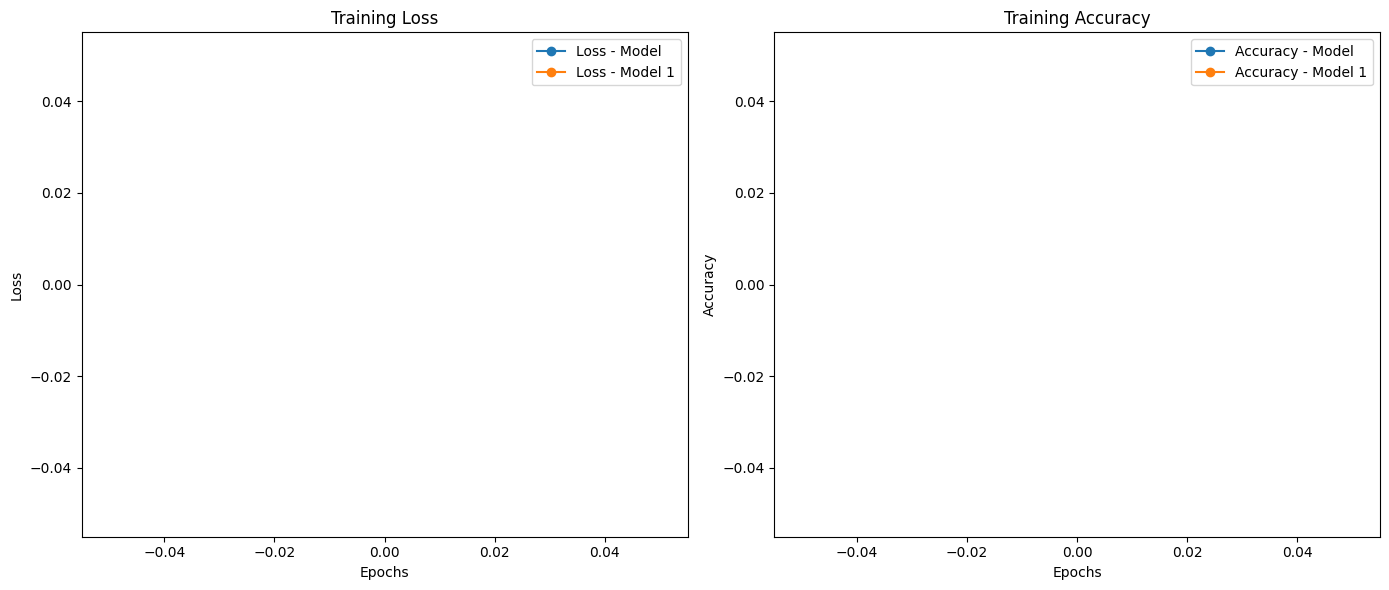

In [19]:
import matplotlib.pyplot as plt
epochs = range(1, len(epoch_losses) + 1)

plt.figure(figsize=(14, 6))

# 绘制 loss 曲线
plt.subplot(1, 2, 1)
plt.plot(epochs, epoch_losses, label='Loss - Model', marker='o')
plt.plot(epochs, epoch_losses_1, label='Loss - Model 1', marker='o')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 绘制 accuracy 曲线
plt.subplot(1, 2, 2)
plt.plot(epochs, epoch_accuracies, label='Accuracy - Model', marker='o')
plt.plot(epochs, epoch_accuracies_1, label='Accuracy - Model 1', marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

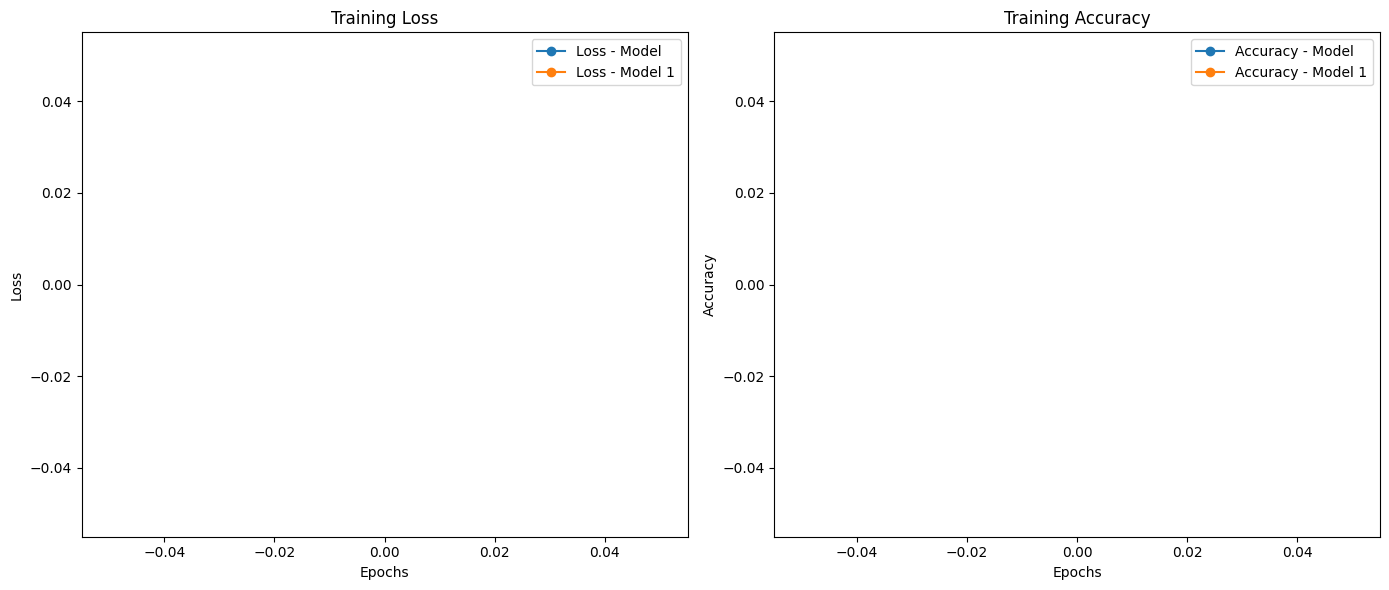

In [20]:
import matplotlib.pyplot as plt
epochs = range(1, len(epoch_losses) + 1)

plt.figure(figsize=(14, 6))

# 绘制 loss 曲线
plt.subplot(1, 2, 1)
plt.plot(epochs, epoch_losses_2, label='Loss - Model', marker='o')
plt.plot(epochs, epoch_losses_3, label='Loss - Model 1', marker='o')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 绘制 accuracy 曲线
plt.subplot(1, 2, 2)
plt.plot(epochs, epoch_accuracies_2, label='Accuracy - Model', marker='o')
plt.plot(epochs, epoch_accuracies_3, label='Accuracy - Model 1', marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
optimizer_client = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
optimizer_client1 = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
###这两个都是客户端的优化梯度

optimizer_server = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
##optimizer_server 和 这两个都是客户端的优化梯度的梯度要一模一样

optimizer_client_1 = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)


optimizer_server_2 = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

In [22]:
#313/313 [==============================] - 1s 3ms/step - loss: 0.9457 - accuracy: 0.7466
#Test loss: 0.9456651210784912, Test accuracy: 0.7465999722480774


## 